# Plotting script for selected ocean variables
this plotting script is for Australian region only


In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dask_jobqueue import PBSCluster
from dask.distributed import Client

In [2]:
import dask
# Set configuration options
dask.config.set({
    'distributed.comm.timeouts.connect': '90s',  # Timeout for connecting to a worker
    'distributed.comm.timeouts.tcp': '90s',  # Timeout for TCP communications
})

client = Client() # Client(threads_per_worker=1) # why?
client


2024-08-21 21:52:57,069 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2024-08-21 21:52:57,071 - distributed.utils - INFO - Reload module schedplugin from .py file
2024-08-21 21:52:57,121 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


<Client: 'tcp://127.0.0.1:45001' processes=4 threads=12, memory=46.00 GiB>

In [3]:
def load_and_mean(file_path, var):
    """
    Load a dataset from a NetCDF file and compute the mean for a specified variable.
    
    Parameters:
        file_path (str): Path to the NetCDF file containing the dataset.
        var (str): Name of the variable in the dataset for which the mean is to be computed.
        
    Returns:
        mean_data (xarray.DataArray): The mean values of the specified variable.
    """
    ds = xr.open_dataset(file_path)
    mean_data = ds[var]
    return mean_data #, ds['xt_ocean'], ds['yt_ocean']

# List of periods and variables
periods = ['GW1p2', 'GW1p5', 'GW2p0', 'GW3p0', 'GW4p0']
base_period = 'GW1p2'


# Load datasets and compute means
means = {}
coords = {}
#data = means[(var, period)]
#vmin = np.nanmin(data.values)
#vmax = np.nanmax(data.values)


##  My plotting script

In [25]:
## %%time
def all_plot(variable, title, base_period,lev1,lev2,scale):
#    variable='duration'
    min_lat=-45; max_lat=-5
    min_lon=100; max_lon=160
    odir='/g/data/xv83/rxm599/acs/hazard_ocean/figures/aus_'

    print(variable )
    print(periods)
    fig, axes = plt.subplots(5, 2, figsize=(22, 24), 
            subplot_kw={'projection': ccrs.PlateCarree(central_longitude=140)}, 
            gridspec_kw={'hspace': 0.2, 'wspace': 0.0})
#            gridspec_kw={'hspace': 0.4, 'wspace': 0.3})
    fig.suptitle(title, fontsize=18, y=0.92, weight='bold')

    data_ref1=means[(variable, base_period)]*scale
    if variable == 'OAR' :
        data_ref2=data_ref1.sel(YT_OCEAN=slice(min_lat,max_lat),XT_OCEAN=slice(min_lon,max_lon))
        data_ref=data_ref2.rename({'YT_OCEAN':'yt_ocean','XT_OCEAN':'xt_ocean'})
    else:
        data_ref=data_ref1.sel(yt_ocean=slice(min_lat,max_lat),xt_ocean=slice(min_lon,max_lon))
    
    for i, period in enumerate(periods):
        print(period) 
        ax = axes[i, 0]
        data1=means[variable,period]*scale
        if variable == 'OAR' :
            data2=data1.sel(YT_OCEAN=slice(min_lat,max_lat),XT_OCEAN=slice(min_lon,max_lon))
            data=data2.rename({'YT_OCEAN':'yt_ocean','XT_OCEAN':'xt_ocean'})
        else:
            data=data1.sel(yt_ocean=slice(min_lat,max_lat),xt_ocean=slice(min_lon,max_lon))

        atmp=area_average(data)
        print('mean', variable,atmp.values  )
        image=data.plot(ax=ax,cmap=plt.cm.Reds,transform=ccrs.PlateCarree(),
           levels=lev1, add_colorbar=False )
        if variable == 'OAR' :
           data[0,:,:].plot.contour(ax=ax,transform=ccrs.PlateCarree(),
           levels=[1], add_colorbar=False, colors='black' )
            
        ax.set_title(f'{period} (Mean)', fontsize=14)
        ax.set_xlabel(' ') #Longitude East')
        ax.set_ylabel(' ') #Latitude')
        ax.coastlines()
        ax.set_xticks(np.arange(min_lon, max_lon+1, 10), crs=ccrs.PlateCarree())  
        ax.set_xticklabels(['100°E','110°E', '120°E', '130°E', '140°E', '150°E', '160°E'])
        ax.set_yticks(np.arange(min_lat, max_lat+1, 10), crs=ccrs.PlateCarree())
        ax.set_yticklabels(['45°S', '35°S', '25°S', '15°S', '5°S'])
        cbar = fig.colorbar( image, ax=ax, orientation='vertical', pad=0.02, fraction=0.05)
        cbar.set_label(title)
# second column
        if period != base_period:
            ax = axes[i, 1]
            diff_data = data - data_ref
            image=diff_data.plot(ax=ax,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree(),
               levels=lev2, add_colorbar=False )
            ax.set_title(f'{period} (Difference)', fontsize=14)
            ax.coastlines()
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_xticks(np.arange(min_lon, max_lon+1, 10), crs=ccrs.PlateCarree())  
            ax.set_xticklabels(['100°E','110°E', '120°E', '130°E', '140°E', '150°E', '160°E'])
            ax.set_yticks(np.arange(min_lat, max_lat+1, 10), crs=ccrs.PlateCarree())
            ax.set_yticklabels(['45°S', '35°S', '25°S', '15°S', '5°S'])
            cbar = fig.colorbar( image, ax=ax, orientation='vertical', pad=0.02, fraction=0.05)
            cbar.set_label(f'{title} Change')
    
    # Remove the unused subplot in the first row, second column
    fig.delaxes(axes[0, 1])

    plt.savefig(odir+f'{variable}.png')
    plt.show()

def get_data(file_template,variables,periods,mean,astr):
# Load datasets and compute means
    means = {}
    coords = {}
    for period in periods:
        for var in variables:
            file_path = file_template.format(period=period)
#            mean_data, lon, lat = load_and_mean(file_path, var)
            mean_data = load_and_mean(file_path, var)
            if mean == True: 
                means[(var, period)] = mean_data.mean(astr)
            else :
                means[(var, period)] = mean_data
#            coords[(var, period)] = (lon, lat)
    return means,coords

def area_average(data):
    weights = np.cos(np.deg2rad(data.yt_ocean))
    weights.name = "weights"
    data_weighted = data.weighted(weights)
    data_weighted
    weighted_mean = data_weighted.mean(("xt_ocean", "yt_ocean"))
    return weighted_mean
    

dhw_amax
['GW1p2', 'GW1p5', 'GW2p0', 'GW3p0', 'GW4p0']
GW1p2
mean dhw_amax 0.0035006402897757097
GW1p5
mean dhw_amax 0.036309510921541256
GW2p0
mean dhw_amax 0.1605190948812953
GW3p0
mean dhw_amax 2.071291072140974
GW4p0
mean dhw_amax 7.576794882250761


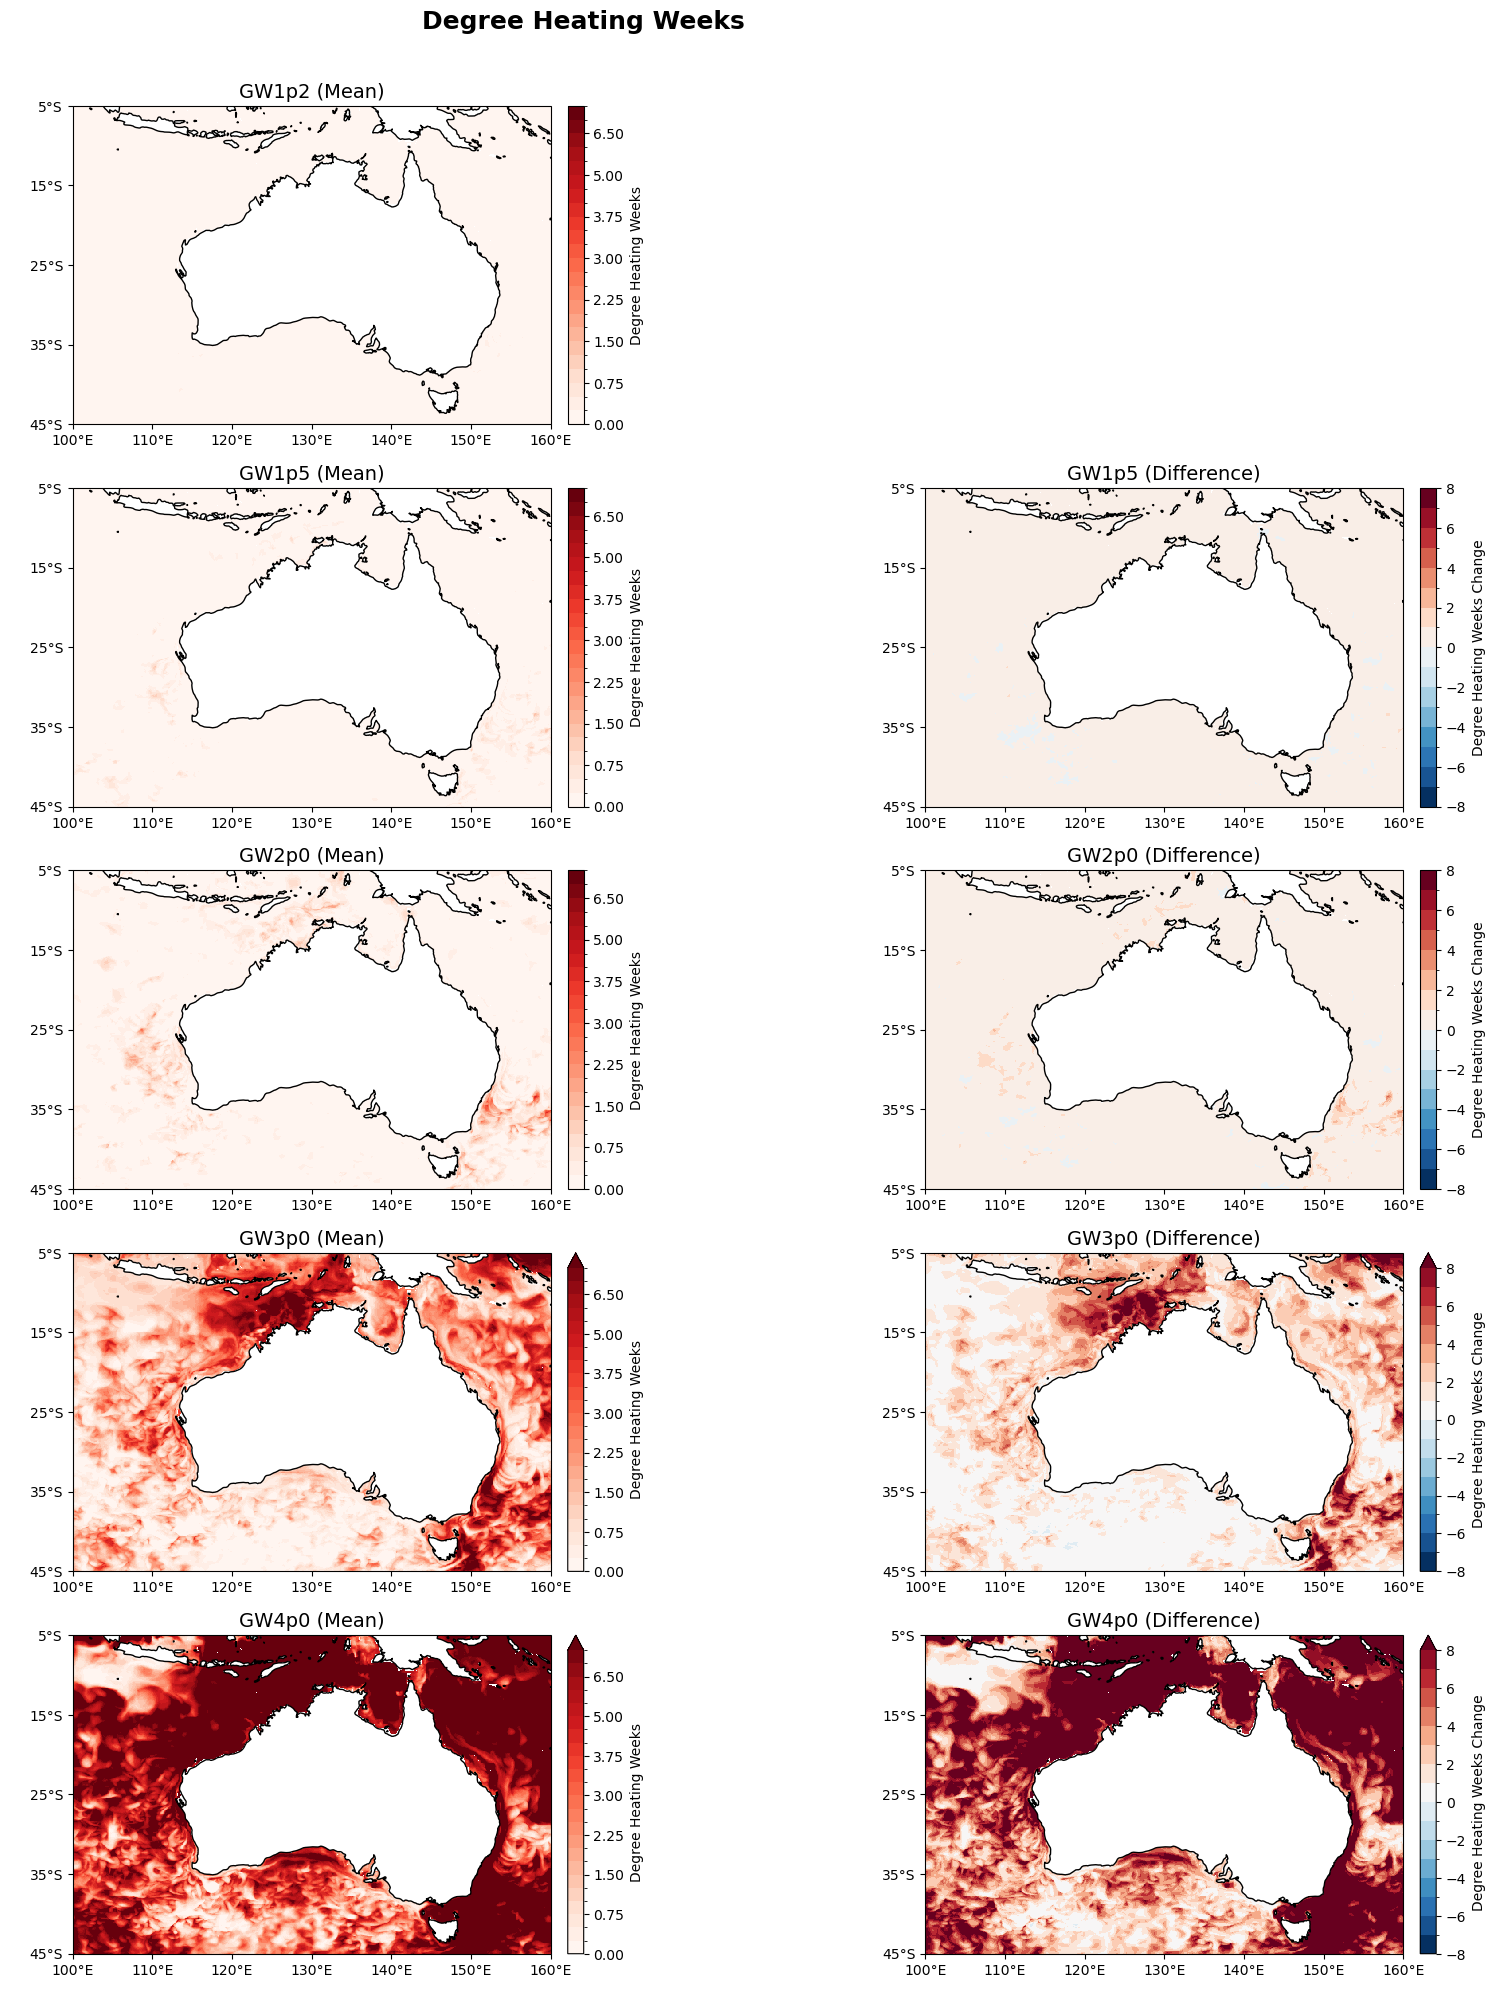

CPU times: user 11.1 s, sys: 1.91 s, total: 13 s
Wall time: 11.5 s


In [26]:
%%time
# Template for the file paths
file_template = "/g/data/ia39/ncra/ocean/{period}_dhw.nc"
variables = ['dhw_amax']

means,coords=get_data(file_template,variables,periods,True,'year')
means['dhw_amax','GW1p2']

a1=np.arange(0,4,.25)
a2=np.arange(4,8,.5)
lev1=np.concatenate([a1, a2])
lev2=range(-8,9,1)
all_plot('dhw_amax','Degree Heating Weeks',base_period,lev1,lev2,1)

temp
['GW1p2', 'GW1p5', 'GW2p0', 'GW3p0', 'GW4p0']
GW1p2
mean temp [23.35156333]
GW1p5
mean temp [23.63343477]
GW2p0
mean temp [24.01458848]
GW3p0
mean temp [24.66933496]
GW4p0
mean temp [25.42845881]


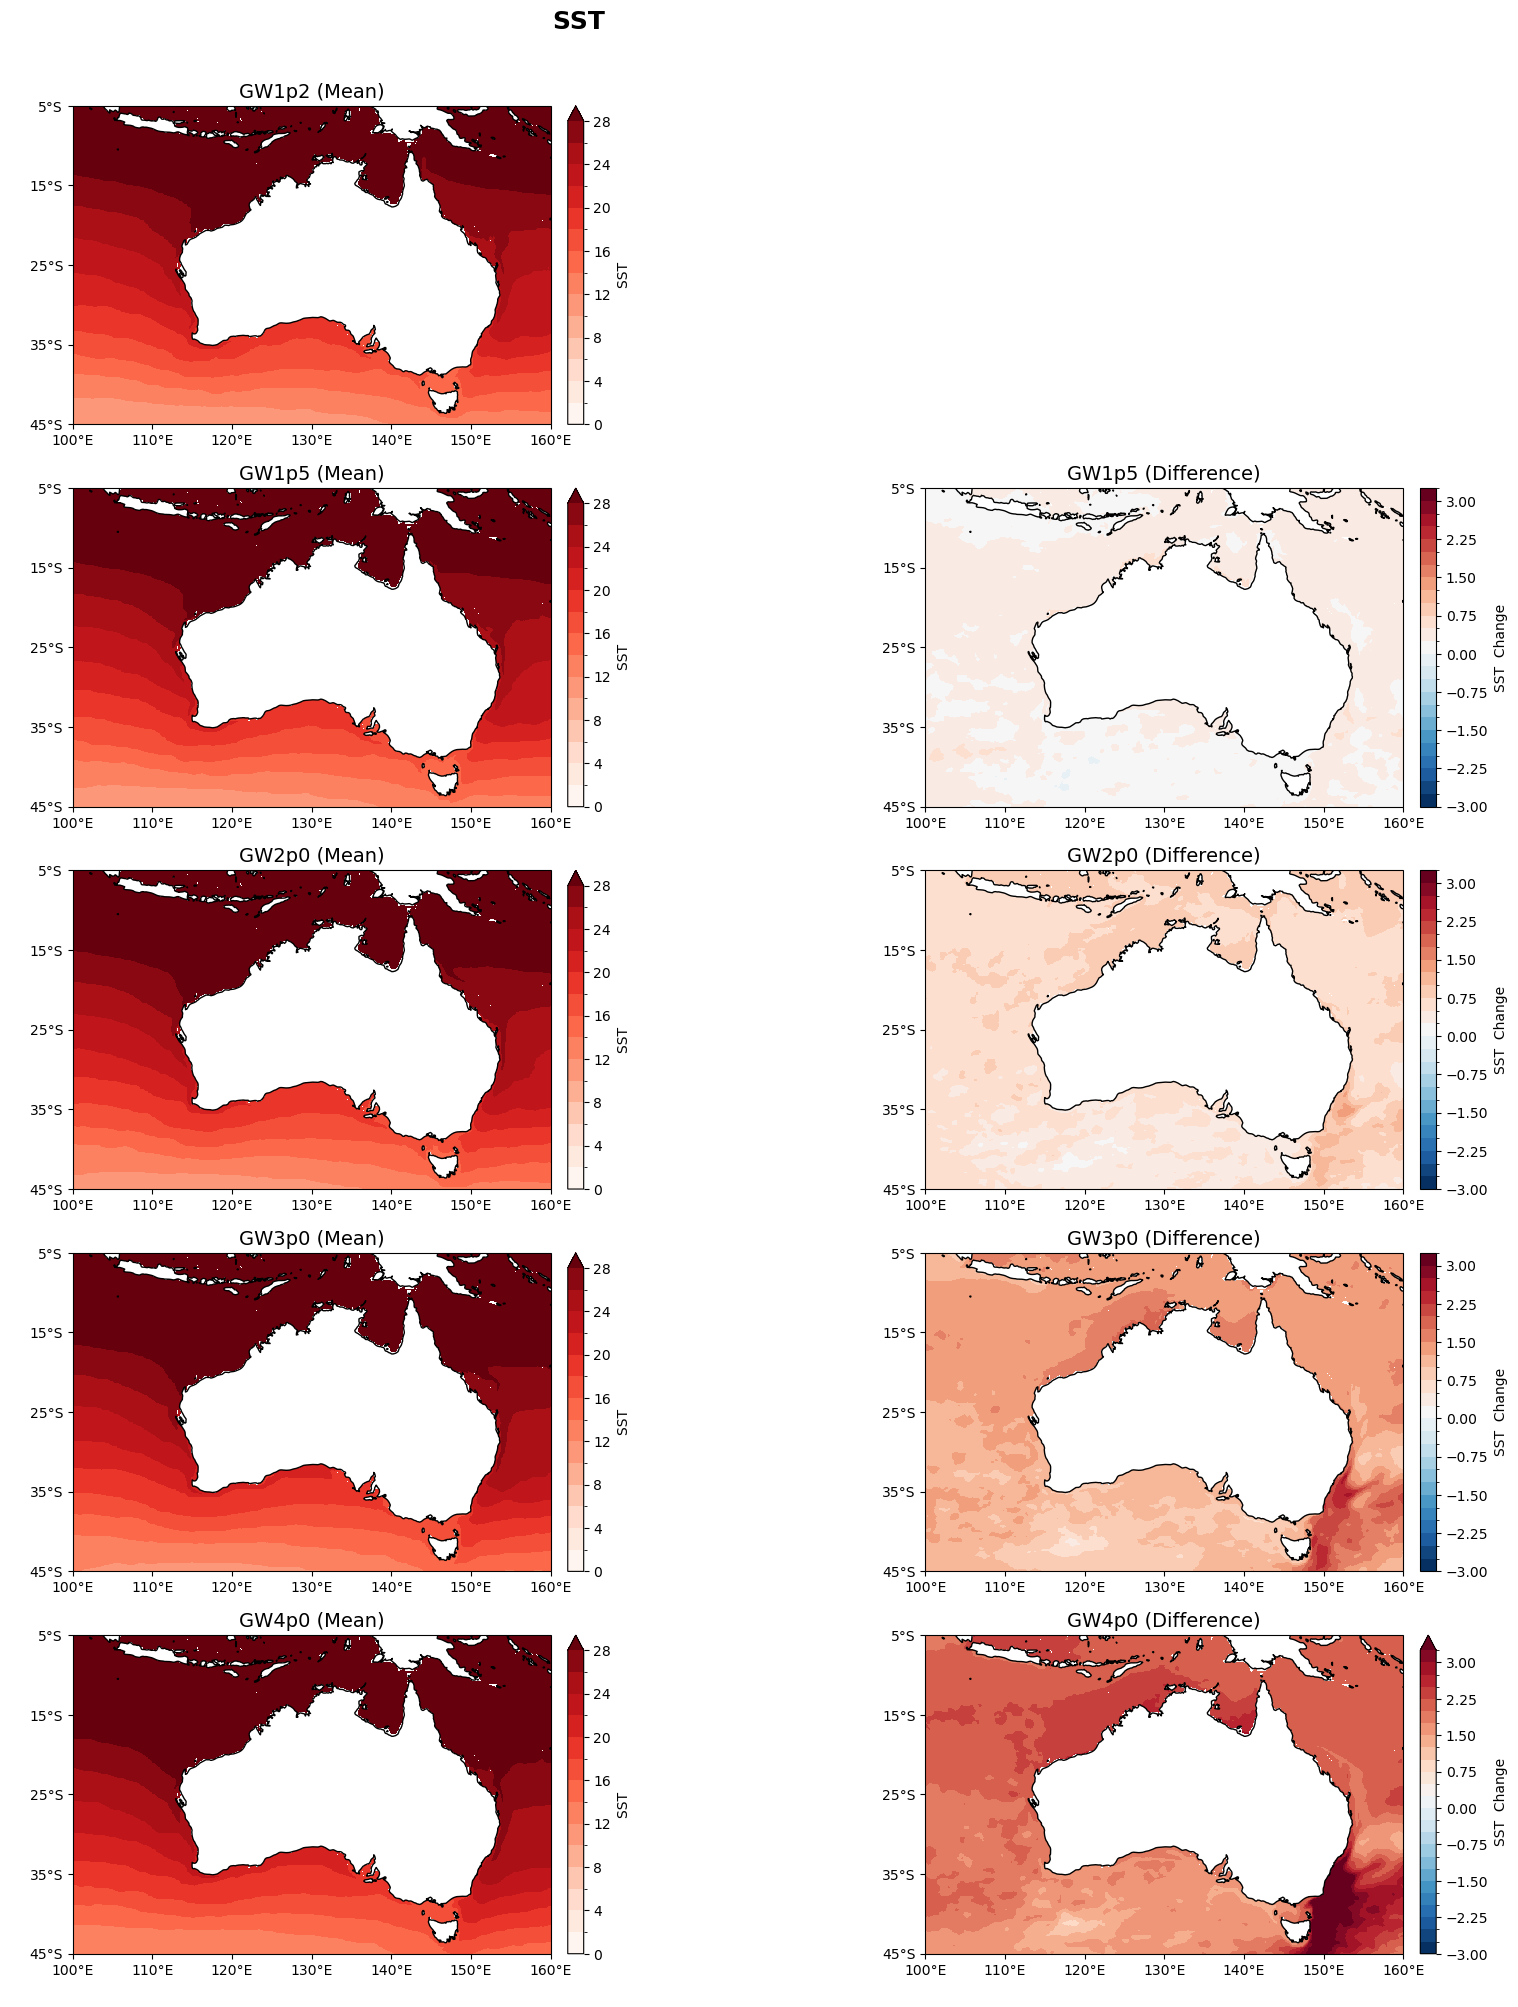

CPU times: user 10.4 s, sys: 1.47 s, total: 11.9 s
Wall time: 10.6 s


In [27]:
%%time
# Template for the file paths
file_template = "/g/data/ia39/ncra/ocean/sst_climatology_{period}.nc"
variables = ['temp']
means,coords=get_data(file_template,variables,periods,True,'month')
#
lev1=np.arange(0,30,2)
lev2=np.arange(-3,3.5,0.25)
all_plot('temp','SST ',base_period,lev1,lev2,1)

pprod_gross_2d
['GW1p2', 'GW1p5', 'GW2p0', 'GW3p0', 'GW4p0']
GW1p2
mean pprod_gross_2d 11.609790198279372
GW1p5
mean pprod_gross_2d 11.276193929214218
GW2p0
mean pprod_gross_2d 11.336788007815093
GW3p0
mean pprod_gross_2d 11.665398431712196
GW4p0
mean pprod_gross_2d 12.022523346709532


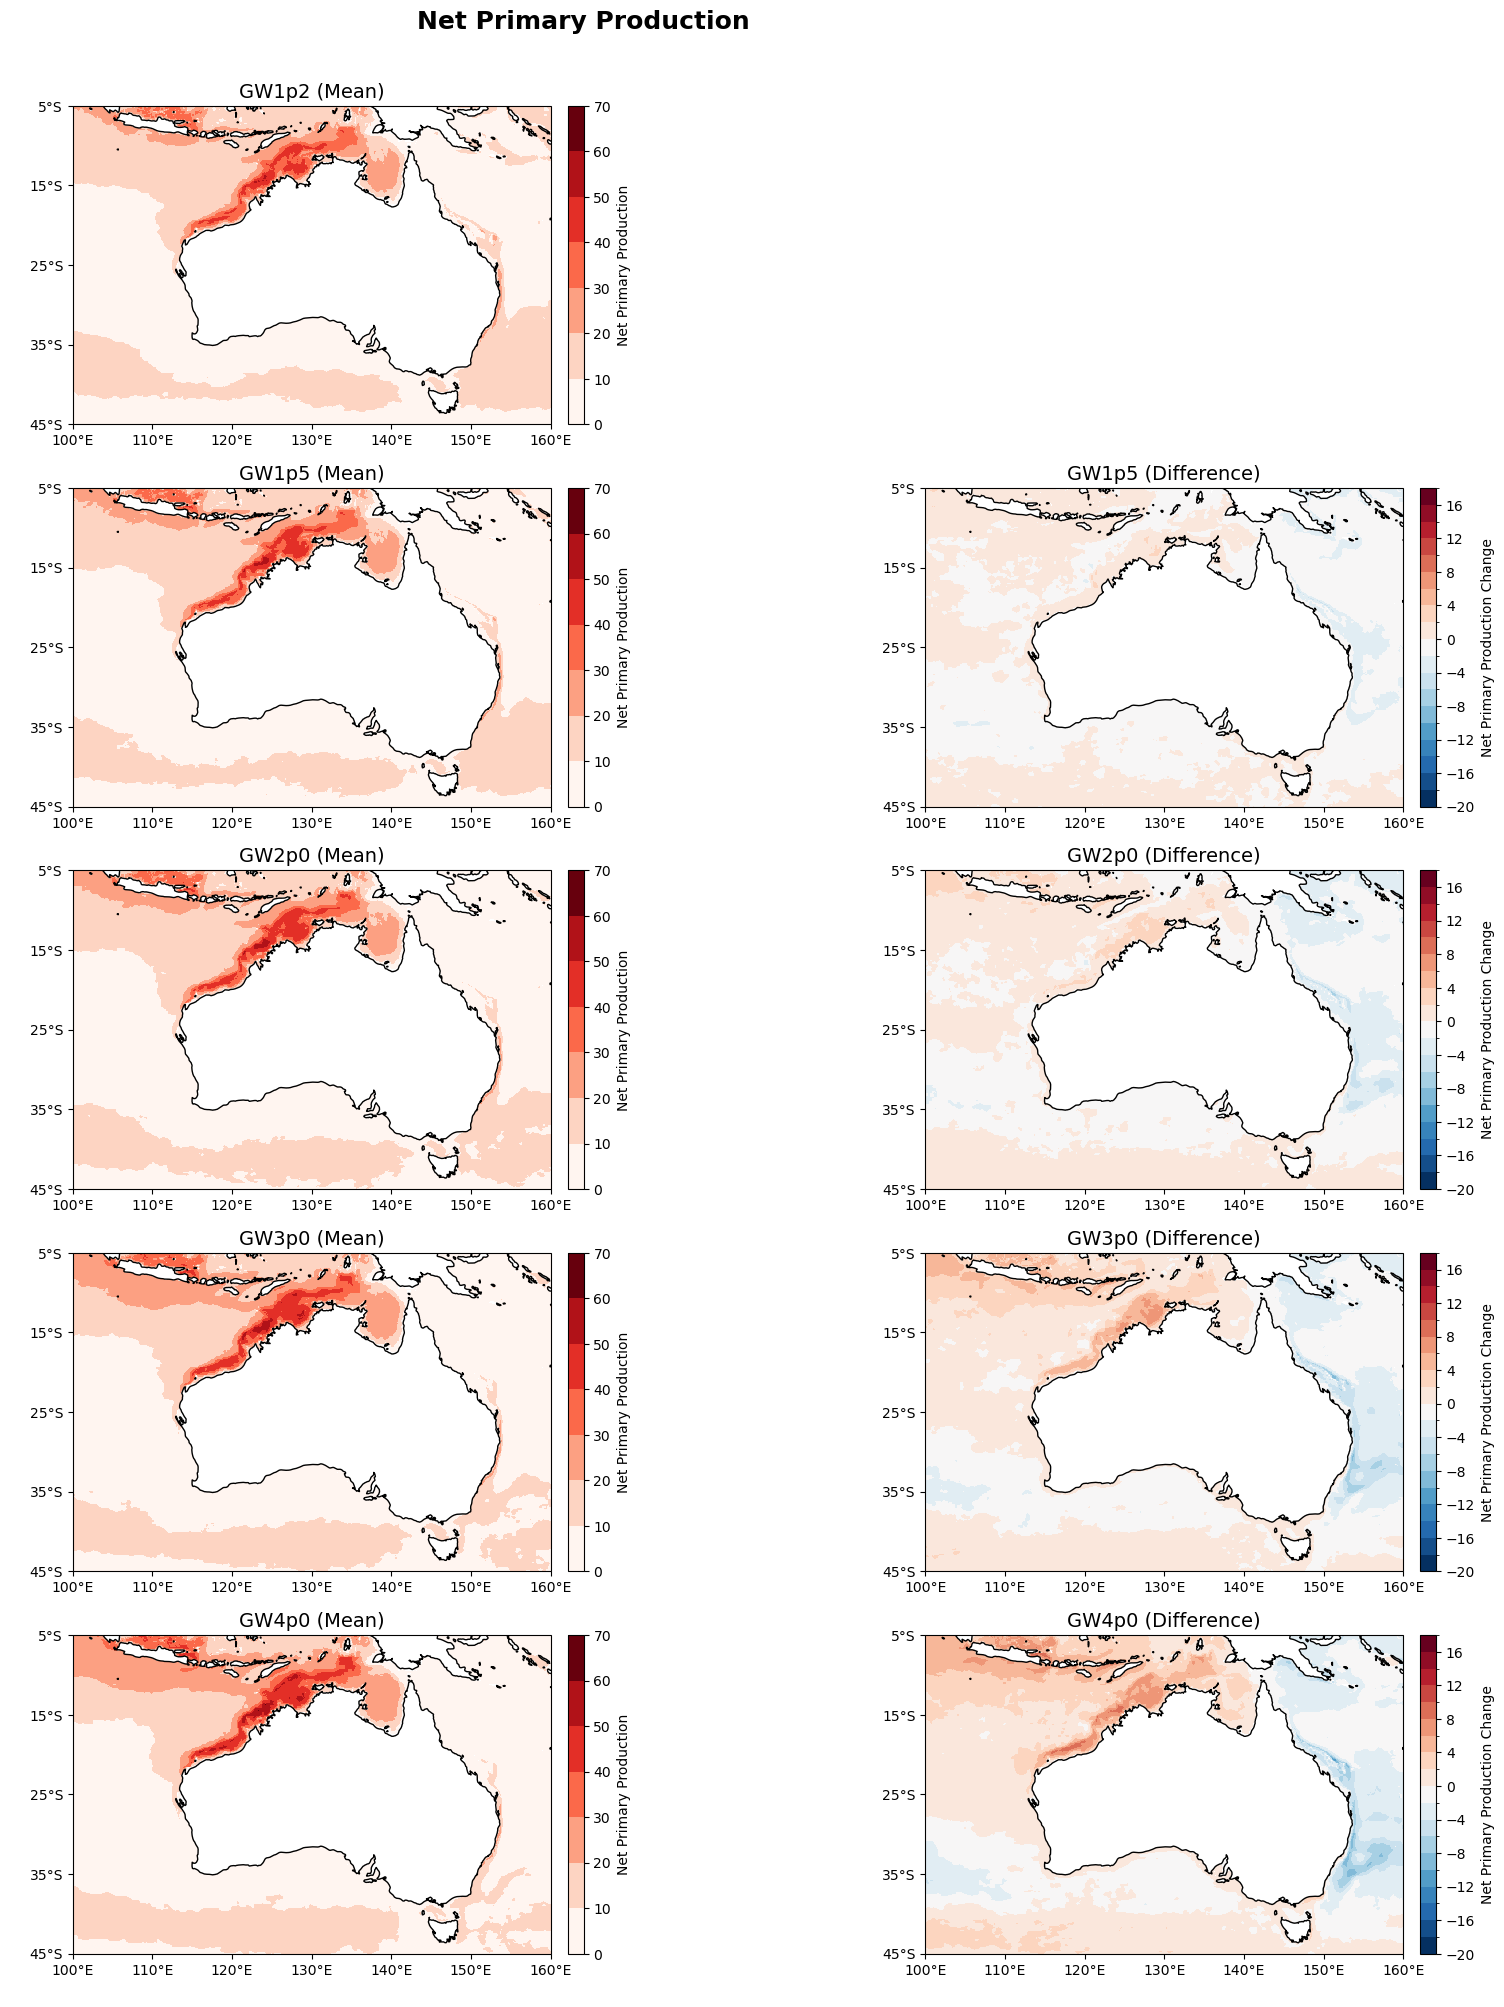

CPU times: user 9.94 s, sys: 1.33 s, total: 11.3 s
Wall time: 10.1 s


In [28]:
%%time
# Template for the file paths
file_template = "/g/data/ia39/ncra/ocean/pprod_gross_2d_climatology_{period}.nc"
variables = ['pprod_gross_2d']
means,coords=get_data(file_template,variables,periods,True,'month')
#
scale=106/16*86400*365*1e-3  # gC /m^2/ y
lev1=np.arange(0,80,10)
lev2=np.arange(-20,20,2)
all_plot('pprod_gross_2d','Net Primary Production',base_period,lev1,lev2,scale)

OAR
['GW1p2', 'GW1p5', 'GW2p0', 'GW3p0', 'GW4p0']
GW1p2
mean OAR [3.28488971]
GW1p5
mean OAR [3.10369823]
GW2p0
mean OAR [2.88486343]
GW3p0
mean OAR [2.48439067]
GW4p0
mean OAR [2.1319303]


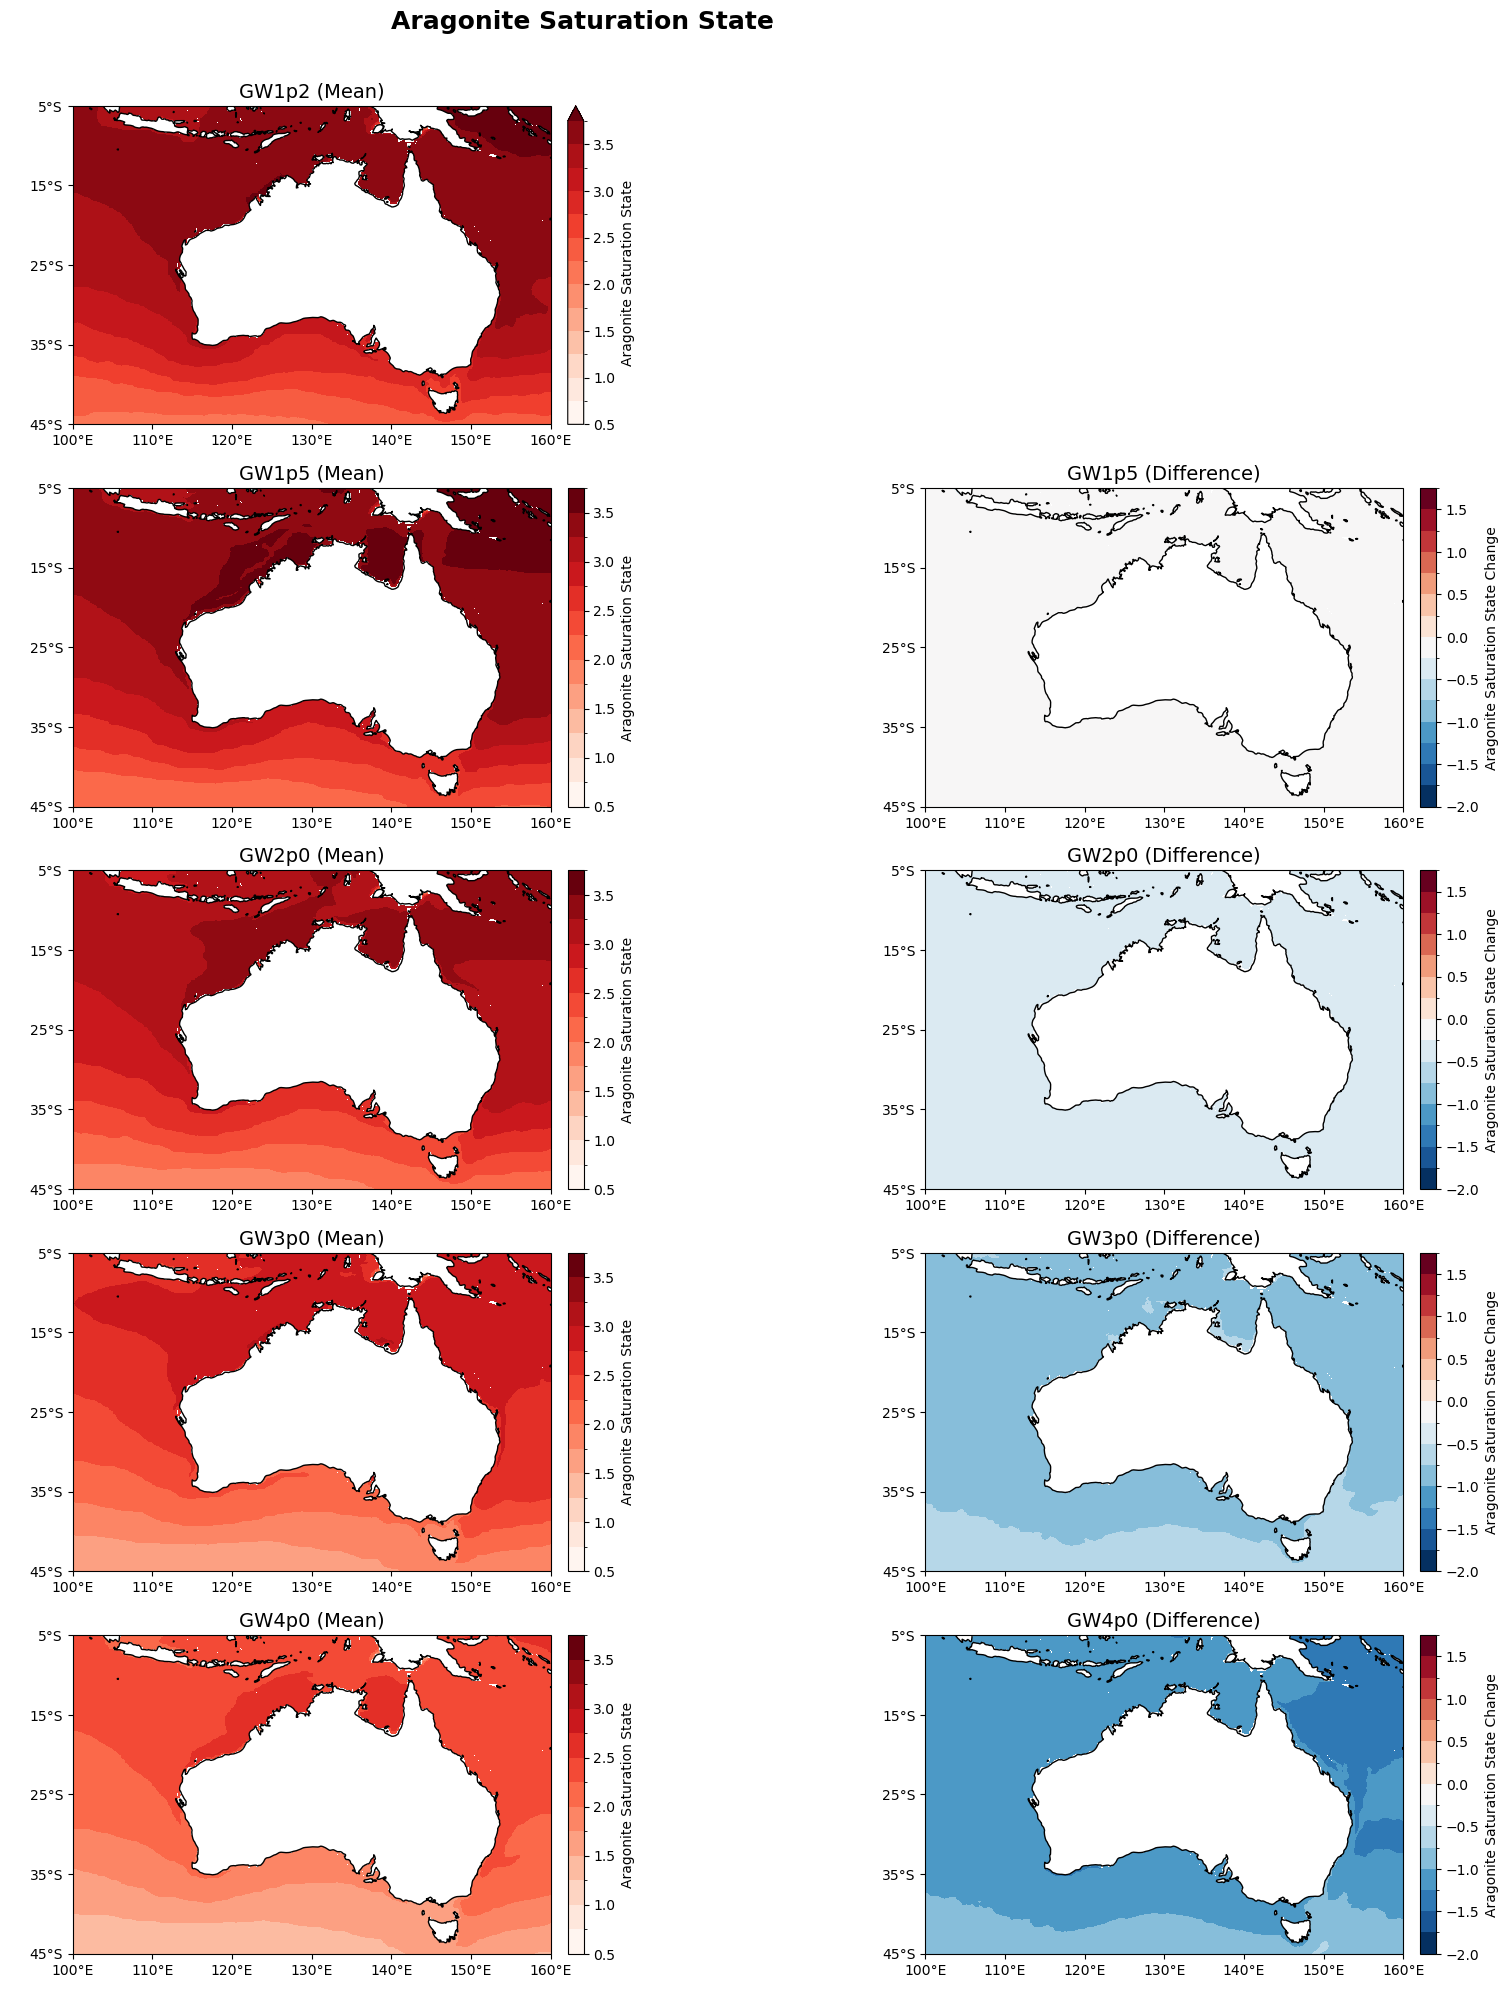

CPU times: user 10.6 s, sys: 1.31 s, total: 11.9 s
Wall time: 10.7 s


In [29]:
%%time
# Template for the file paths
file_template = "/g/data/ia39/ncra/ocean/OAR_climatology_{period}.nc"
variables = ['OAR']
means,coords=get_data(file_template,variables,periods,True,'month')
#

lev1=np.arange(.5,4,.25)
lev2=np.arange(-2,2,.25)
all_plot('OAR','Aragonite Saturation State',base_period,lev1,lev2,1)

duration
['GW1p2', 'GW1p5', 'GW2p0', 'GW3p0', 'GW4p0']
GW1p2
mean duration 17.93852594934481
GW1p5
mean duration 39.605605814365354
GW2p0
mean duration 95.03615911559719
GW3p0
mean duration 178.89005412368422
GW4p0
mean duration 224.75679640334022


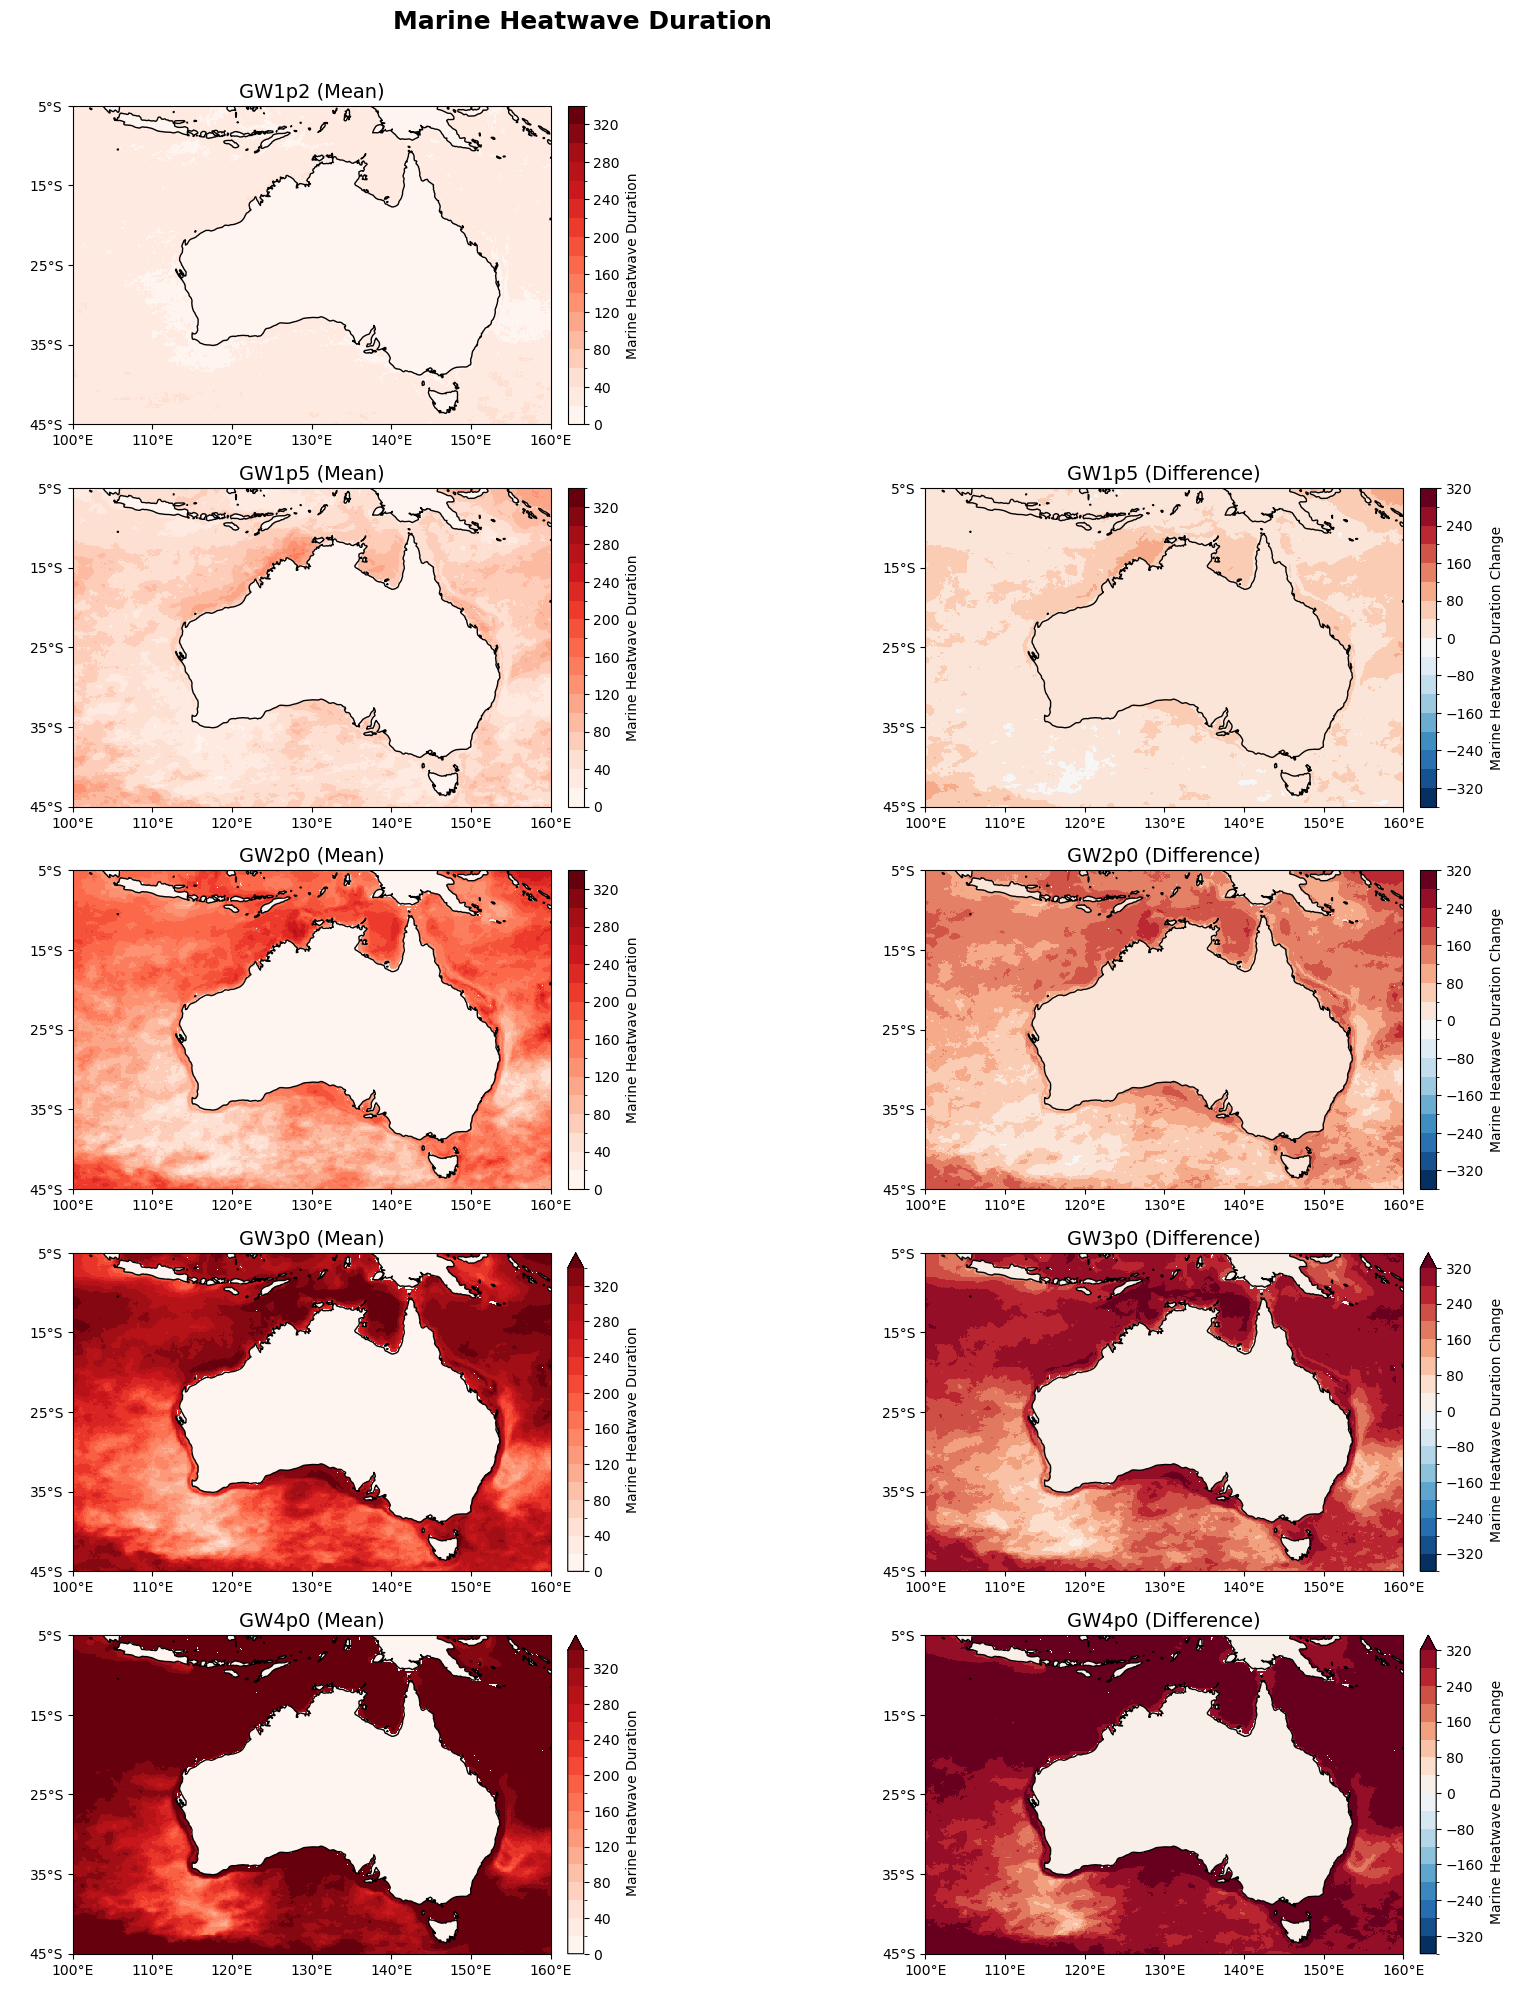

magnitude
['GW1p2', 'GW1p5', 'GW2p0', 'GW3p0', 'GW4p0']
GW1p2
mean magnitude 0.022773906530845097
GW1p5
mean magnitude 0.06798566885136363
GW2p0
mean magnitude 0.21144856584516486
GW3p0
mean magnitude 0.6313204999715663
GW4p0
mean magnitude 1.2983812792935328


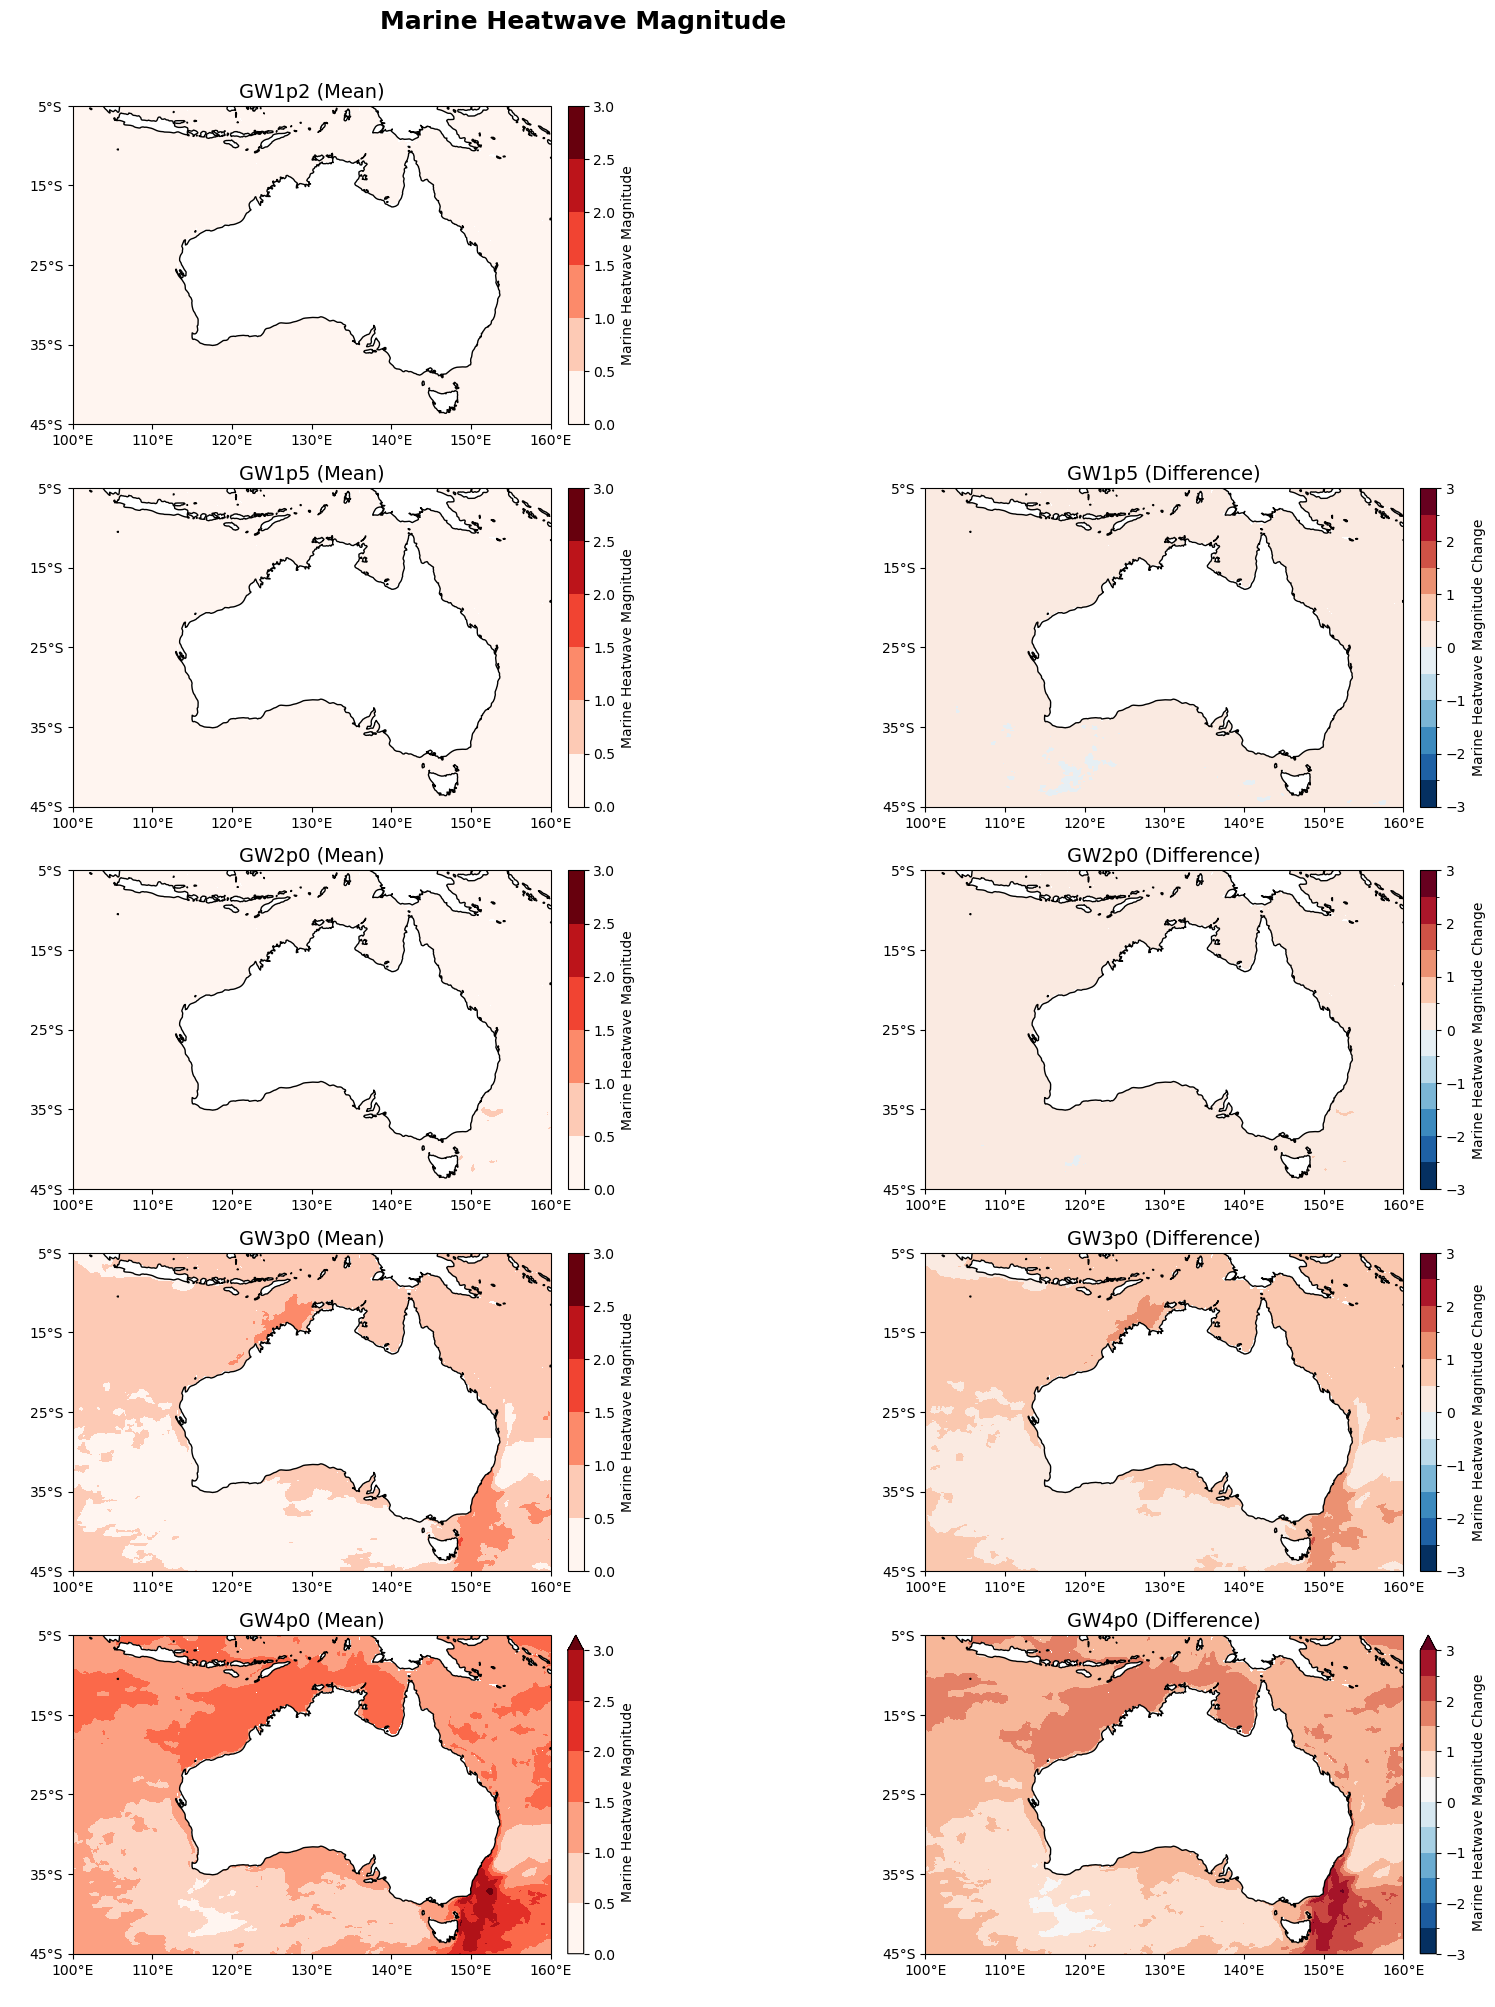

CPU times: user 17.2 s, sys: 1.46 s, total: 18.7 s
Wall time: 16.7 s


In [30]:
%%time
# Template for the file paths
file_template = "/g/data/ia39/ncra/ocean/{period}_mhw.nc"
variables = ['duration','magnitude']

means,coords=get_data(file_template,variables,periods,False,'year')
means['duration','GW1p2']

lev1=range(0,360,20)
lev2=range(-360,360,40)
all_plot('duration','Marine Heatwave Duration',base_period,lev1,lev2,1)
lev1=np.arange(0,3.5,.5)
lev2=np.arange(-3,3.5,.5)
all_plot('magnitude','Marine Heatwave Magnitude',base_period,lev1,lev2,1)



## End

In [ ]:
client.close()

In [20]:
data=means['OAR','GW1p2']
data1=data.rename({'YT_OCEAN':'yt_ocean','XT_OCEAN':'xt_ocean'})
data1

<xarray.DataArray 'OAR' (ST_OCEAN: 1, yt_ocean: 1500, xt_ocean: 3600)> Size: 22MB
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [1.8517927, 1.852377 , 1.8529744, ..., 1.8505859, 1.851055 ,
         1.8514414],
        [1.8634243, 1.8641773, 1.8649172, ..., 1.8613962, 1.862062 ,
         1.8627323],
        [1.8796325, 1.88015  , 1.8806311, ..., 1.8782712, 1.878755 ,
         1.8791981]]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB 0.05 0.15 0.25 0.35 ... 359.8 359.9 360.0
  * yt_ocean  (yt_ocean) float64 12kB -74.95 -74.85 -74.75 ... 74.75 74.85 74.95
  * ST_OCEAN  (ST_OCEAN) float64 8B 2.5